In [2]:
completePath = "data/energydata_complete.csv"
trainingPath = "data/training.csv"
testingPath = "data/testing.csv"

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [4]:
df = pd.read_csv(completePath)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


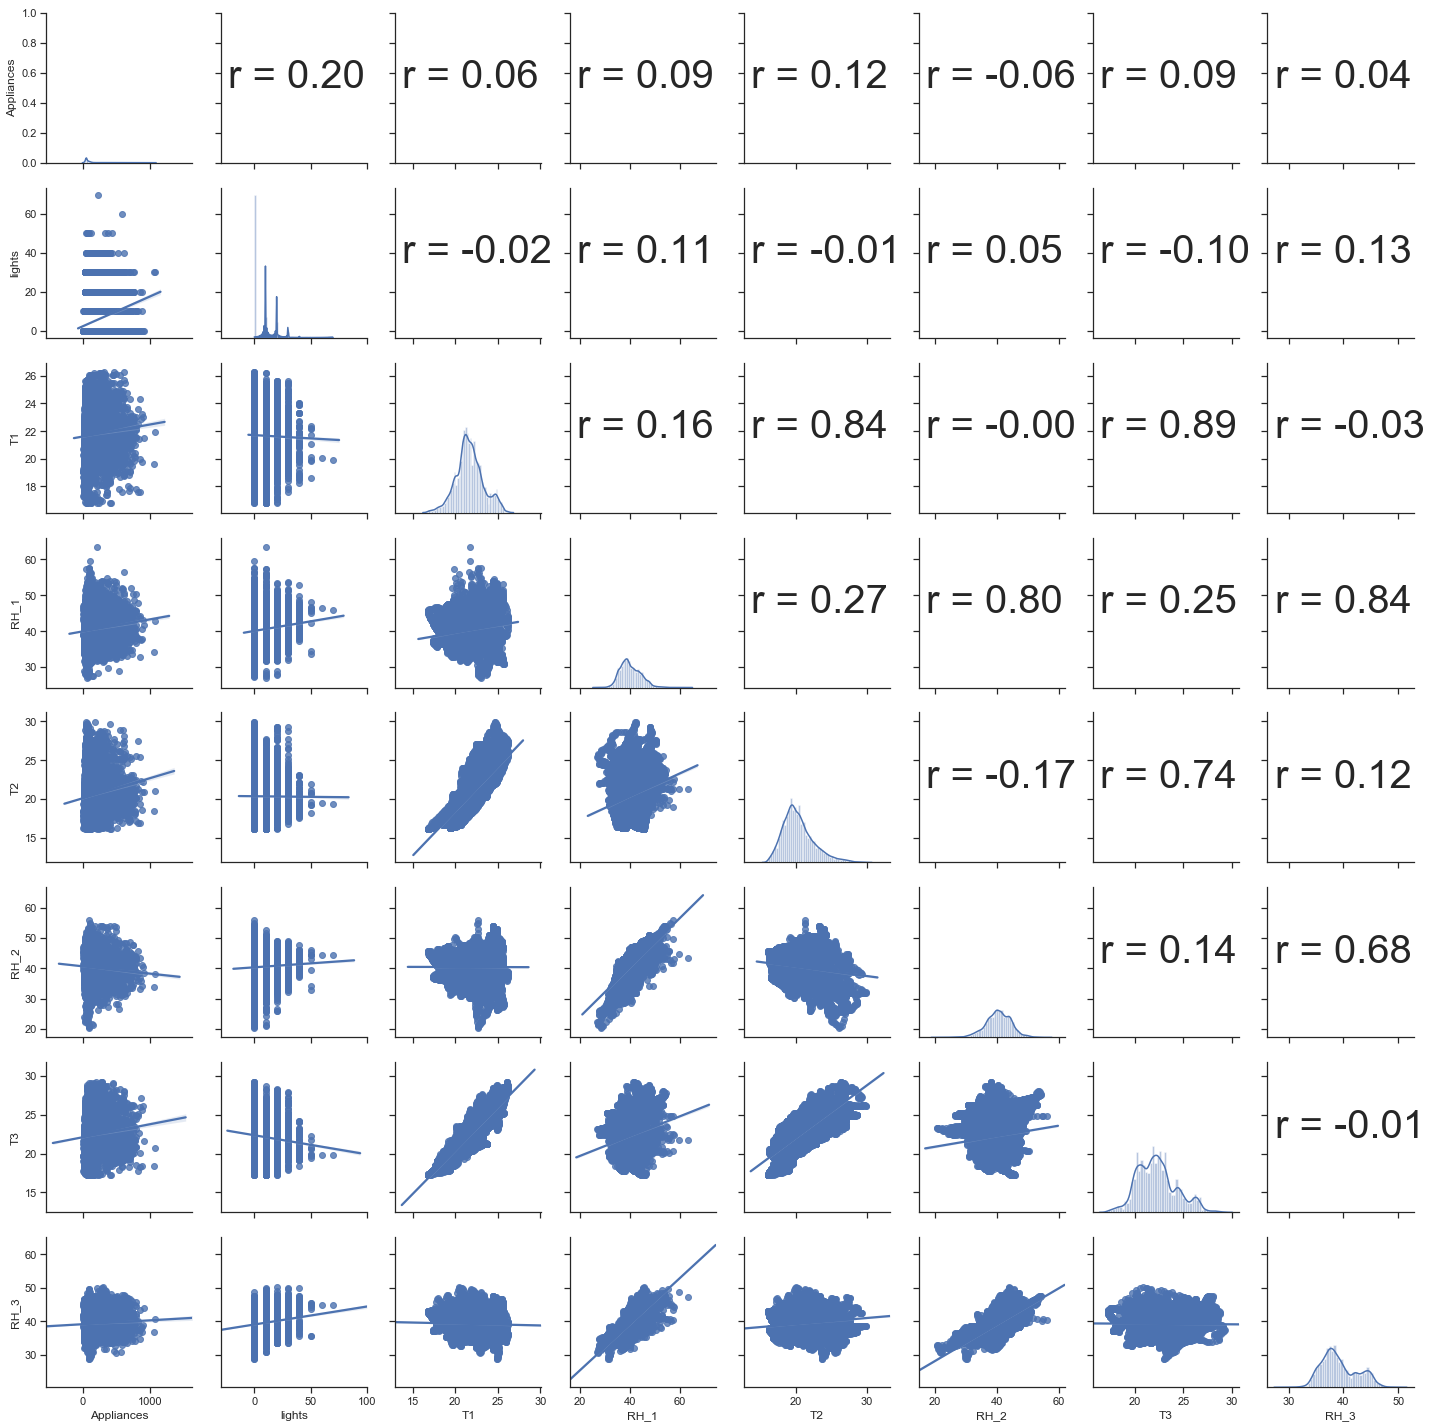

In [4]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(0.05, .5), xycoords=ax.transAxes,size=40)

sns.set(style="ticks", color_codes=True)
pairp = sns.PairGrid(df,vars=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3','RH_3'])
pairp.map_diag(sns.distplot)
pairp.map_lower(sns.regplot)
pairp.map_upper(corrfunc)
None

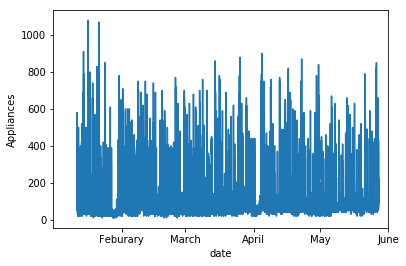

In [5]:
df['date'] = pd.to_datetime(df['date'])
dayMap = dict(zip([6]+list(range(0,6)),range(0,7))) #so the 1st day is sunday not monday
monthNames = ['January', 'Feburary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['week'],df['day'],df['hour'],df['month'] = df['date'].map(lambda x: x.isocalendar()[1]) ,df['date'].map(lambda x: dayMap[x.weekday()]) ,df['date'].map(lambda x: x.hour),df['date'].map(lambda x: x.month)
df = df.sort_values('date')
ticks = [pd.datetime(2016,e,1,0) for e in range (2,7)]

mLine = sns.lineplot(df['date'],df['Appliances'])
mLine.set_xticks(ticks)
mLine.set(xticklabels=[monthNames[e.month-1] for e in ticks]) #-1 so that the tick represents the END of the month
mLine.set(xlim =(pd.datetime(2016,1,1,0), pd.datetime(2016,6,1,0)))
None

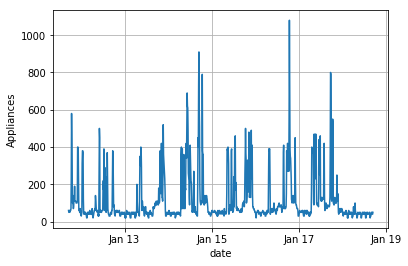

In [75]:
wLine = sns.lineplot(df['date'][1:1008],df['Appliances'][1:1008])
ticks = [pd.datetime(2016,1,13 + e,0) for e in range (0,8,2)]
wLine.set_xticks(ticks)
wLine.set(xticklabels=["Jan " + str(e.day) for e in ticks])
wLine.grid(True)
None

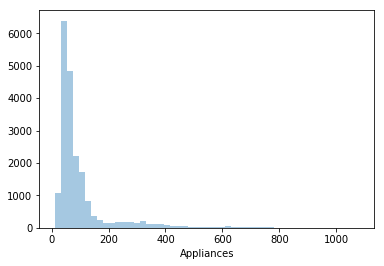

In [77]:
sns.distplot(df['Appliances'], kde=False)
None

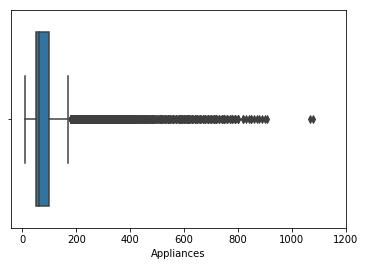

In [81]:
fig,ax = 
g = sns.boxplot(df['Appliances'])
g.set_xticks(range(0,1201,200))
None

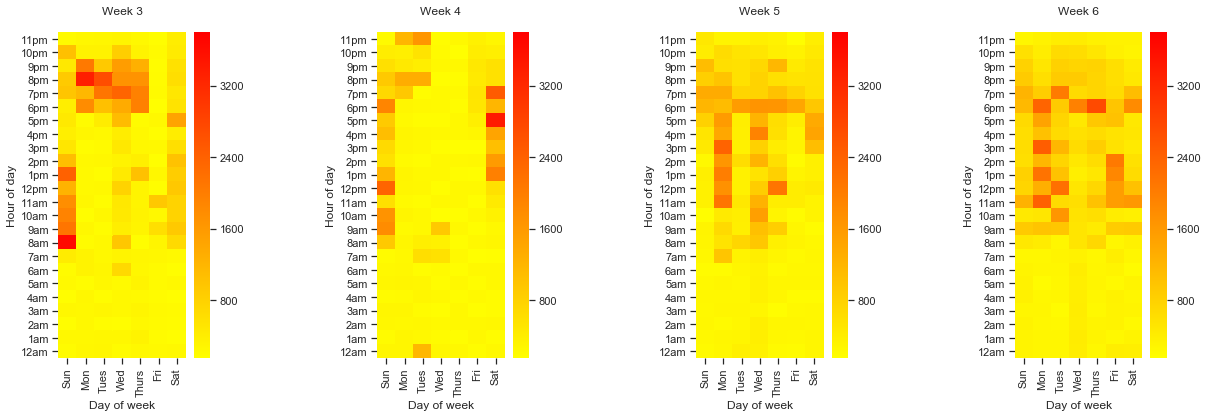

In [70]:
hourLables = (["12am"] + [str(e)+"am"  for e in range(1,12)] + ["12pm"] + [str(e)+"pm"  for e in range(1,12)])[::-1]
dayNames = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']

weeks = range(3,7)
fig, axArr = plt.subplots(1,len(weeks),figsize=(20,6), gridspec_kw=dict(wspace=1))
for week,ax in zip(weeks,axArr):
    pivot = pd.pivot_table(df[df['week'] == week] [['day','hour', 'Appliances']], index=['day', 'hour'], aggfunc='sum')
    unstacked = pivot.unstack(level=0)
    ax = sns.heatmap(unstacked.sort_index(ascending=False), fmt="d", ax=ax,cmap='autumn_r',vmin=150, vmax=3800,xticklabels=dayNames,yticklabels=hourLables)
    ax.axes.set_title(f"Week {week}\n")
    ax.set(xlabel='Day of week', ylabel='Hour of day');
plt.show()

## Hourly usage heatmap

here i took the first 4 weeks (3-6) and i created a heatmap for each week, i had to dig around the R notebook to reproduce this properly, the hardwired heat map max/min are taken directly from it aswell as the weeks.
<br><br>
Its worth noting that the week 6's heatmap seems visually different as it has an "L" shape at Fri/Sat at around midday where was the paper does not, i took some time to ensure i was sampling correctly and came to reason it was due to differing gradients as i have the same timestamps and week selected in that heatmap.

In [ ]:
predictors = df_train.drop('Appliances', axis=1)._get_numeric_data()
linRegression = LinearRegression(normalize=True)
linRegression = linRegression.fit(predictors,df_train['Appliances'])
coefs = pd.DataFrame({'coef':linRegression.coef_,"name":predictors.columns.values}).set_index('name')

fig, ax = plt.subplots(figsize=(4,15))
sns.heatmap(coefs,annot=True, center=0,vmin=-25,vmax=25,ax=ax)
None


In [ ]:
yHat = linRegression.predict(predictors)
y = df_train['Appliances']
residuals = yHat - y

sns.scatterplot(residuals,y)

## Pairs plot reproduction

Here i have tried to recreate the exact plot from the paper with some custom code, all the plots and correlation coefficients look the same

In [ ]:
df_train = pd.read_csv(trainingPath)
estimator = LinearRegression(normalize=True)
selector = RFE(estimator)
selector = selector.fit(predictors,df_train['Appliances'])
df_masked = df_train[predictors.columns[selector.support_]]

In [ ]:
rankings = pd.DataFrame({'name':predictors.columns,'rank':selector.ranking_,'support':selector.support_}).set_index('name').sort_values('rank')
rankings

In [ ]:
print(f"Total predictors:   {len(df_train.columns.values)}")
print(f"Numeric predictors: {len(predictors.columns.values)}")
print(f"Reduced amount:     {len(df_masked.columns.values)}")

## RFE reproduction

above is the reproduction of using recursive feature eliminations with SKLearn, i opted to normalize the data, it resulted in 14 of the 28 numeric variables being kept, this varies from the paper as it started with 35 variables and reduced them down to 35

In [ ]:
predictors = df_masked
linRegression = LinearRegression(normalize=True)
linRegression = linRegression.fit(predictors,df_train['Appliances'])
coefs = pd.DataFrame({'coef':linRegression.coef_,"name":predictors.columns.values}).set_index('name')

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(coefs,annot=True, center=0,vmin=-25,vmax=25,ax=ax)
None

## Post reduction correlation

above is the coeficents maped to colors where light blue is strong negative and light red is strong positive correlation. here we can see much more of our coeffiecnts (witch we normalize earlier meaning we can compare them) are much stronger as we threw away a large amount of the weaker ones

In [ ]:
yHat = linRegression.predict(predictors)
y = df_train['Appliances']
residuals = yHat - y

sns.scatterplot(residuals,y)